In this file, we demonstrate the training and usage of SURE. Before running the example code in this file, please prepare the data according to the process described in the previous file.

First, we use the shell to invoke commands to train the SURE model. In the following command:
- `--data-file` is used to specify the file containing the single-cell transcriptome data. It can be a csv or tsv file, where rows represent cells and columns represent genes. Do not set row names for each row, meaning there is no need to set an index.
- `--undesired-factor-file` is used to specify the file containing the undesired factor values. Undesired factors can be batch, sample, or any other factors that you wish to remove from the data. Users can set the undesired factors based on their actual problem requirements.
- `--jit` is used to enable Jax acceleration. It is worth noting that if users want to use this feature, both `--data-file` and `--undesired-factor-file` need to be provided. If the user only sets `--data-file` and uses `--jit`, the program will encounter an error.
- `-cd` is used to set the number of metacells.
- `-lr` is the learning rate.
- `-n` is the number of epochs.
- `-bs` is the batch size.
- `-zi exact` is used to specify the exact form of the zero-inflated model.
- `-dirichlet` is used to specify the Dirichlet-multinomial distribution.
- `-likeli negbinomial` is used to specify the negative binomial distribution model for calculating the data likelihood.

In [1]:
%%bash

CUDA_VISIBLE_DEVICES=0  python SURE.py --data-file "/home/oem/SURE_example_4/heart_atac_counts.txt.gz" \
                        --undesired-factor-file "/home/oem/SURE_example_4/heart_atac_uwv.txt.gz" \
                        --jit \
                        -rt \
                        -cd 500 \
                        -lr 0.0001 \
                        -n 300 \
                        -bs 1000 \
                        --seed 0 \
                        --cuda \
                        -zi exact \
                        -dirichlet \
                        -likeli negbinomial \
                        --save-model "sure_4_heart_atac.pth" 2>&1 | tee "sure_4_heart_atac.log"

/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
1 epoch: avg losses 14820490.6277 elapsed 16.0795 seconds
2 epoch: avg losses 14097200.0399 elapsed 1.4765 seconds
3 epoch: avg losses 13946888.4761 elapsed 1.4692 seconds
4 epoch: avg losses 13871036.2766 elapsed 1.4680 seconds
5 epoch: avg losses 13807648.6330 elapsed 1.4700 seconds
6 epoch: avg losses 13740914.8218 elapsed 1.4657 seconds
7 epoch: avg losses 13665462.9761 elapsed 1.4728 seconds
8 epoch: avg losses 13574427.5053 elapsed 1.5294 seconds
9 epoch: avg losses 13476120.7021 elapsed 1.4707 seconds
10 epoch: avg losses 13380744.3218 elapsed 1.4701 seconds
11 epoch: avg losses 13328854.8165 elapsed 1.4703 seconds
12 epoch: avg losses 13306952.1223 elapsed 1.4699 seconds
13 epoch: avg losses 13291914.1436 elapsed 1.4703 seconds
14 epoch: avg losses 13275

Set up the Python environment and load some necessary packages.

Here, we use R for plotting, so we need to use [rpy2](https://rpy2.github.io/). If users want to try running these R code snippets, they need to install these Python packages. If there is no need to run these R code snippets, please ignore them directly.

In [2]:

import numpy as np
import pandas as pd

from SURE import SURE
from utils.scdata_cached import setup_data_loader, SingleCellCached

import torch
from torch.utils.data import DataLoader

import datatable as dt


# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks

pandas2ri.activate()

%load_ext rpy2.ipython


/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:

ModelPath = 'sure_4_heart_atac.pth'
DataPath='/home/oem/SURE_example_4/heart_atac_counts.txt.gz'


In [4]:
# load model
model = torch.load(ModelPath)

batch_size = 10000

use_float64 = False
use_cuda = True
log_trans = False

In [5]:
# load data
data_cached = SingleCellCached(DataPath, None, log_trans=log_trans, use_cuda=False, use_float64 = use_float64)
data_loader = DataLoader(data_cached, batch_size = batch_size, shuffle = False)

#### Get the latent representations of cells

In [6]:
embeds = []
weights = []

for xs1,ks2 in data_loader:
    if use_cuda:
        xs1 = xs1.cuda()

    zs = model.get_cell_coordinates(xs1)
    ws = model.soft_assignments(xs1)
    
    if use_cuda:
        zs = zs.cpu().detach().numpy()
        ws = ws.cpu().detach().numpy()
    else:
        zs = zs.detach().numpy()
        ws = ws.detach().numpy()

    embeds.append(zs)
    weights.append(ws)

embeds = np.concatenate(embeds, axis=0)
weights = np.concatenate(weights, axis=0)


cells = pd.read_csv('/home/oem/SURE_example_4/heart_atac_cell.csv.gz', header=0)
genes = pd.read_csv('/home/oem/SURE_example_4/heart_atac_gene.csv.gz', header=0)

df = pd.DataFrame(embeds, index=cells.iloc[:,0].values).reset_index()
dt.Frame(df).to_csv('/home/oem/SURE_example_4/heart_atac_embeds.csv.gz')

df=pd.DataFrame(weights, index=cells.iloc[:,0].values)
dt.Frame(df.reset_index()).to_csv('/home/oem/SURE_example_4/heart_atac_weights.csv.gz')

#### Get the latent representations of metacells

In [7]:
codebook=model.get_metacell_coordinates().cpu().detach().numpy()
pd.DataFrame(codebook).to_csv('/home/oem/SURE_example_4/heart_atac_codebook.csv.gz')

#### Load H5AD files

In [8]:
import scanpy as sc

adata = sc.read_h5ad('/home/oem/SURE_example_4/9bc3febe-9043-4781-bb87-b8647c4f2162.h5ad')
meta = adata.obs

#### Invoke R to plot and display the latent representations of cells and metacells.

In [9]:
%%R -i meta 

library(Seurat)
library(dplyr)
library(useful)
library(data.table)
library(ggplot2)
library(cowplot)
library(uwot)

set.seed(123)

scp <- fread('/home/oem/SURE_example_4/heart_atac_embeds.csv.gz', data.table = FALSE, header = TRUE)
rownames(scp) <- scp[,1]
scp <- scp[,-1]

embed.list <- umap(scp, n_threads = 40, pca=NULL, ret_model = TRUE)
embed <- embed.list$embedding
colnames(embed) <- c('UMAP_1','UMAP_2')



recon <- CreateSeuratObject(scp[,1:5] %>% as.matrix %>% t, meta.data = meta[rownames(scp),])
recon[['umap']] <- CreateDimReducObject(embed %>% as.matrix(), key = 'UMAP_')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SeuratObject
Loading required package: sp
‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Attaching package: ‘SeuratObject’

The following object is masked from ‘package:base’:

    intersect


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
data.table 1.14.10 using 6 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Loading required package: Matrix
In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-libra

In [10]:
%%R 

codebook <- read.csv('/home/oem/SURE_example_4/heart_atac_codebook.csv.gz', row.names = 1)
embed_cb <- umap_transform(codebook, embed.list) %>% as.data.frame()
colnames(embed_cb) <- c('UMAP_1','UMAP_2')

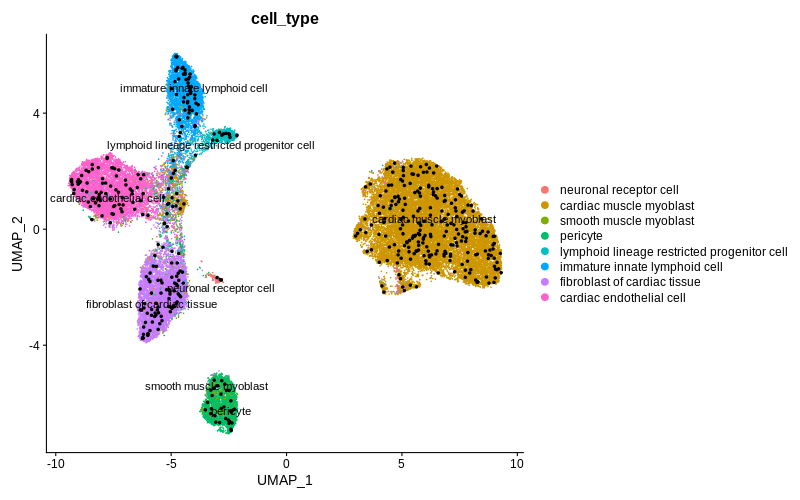

In [11]:
%%R -w 800 -h 500 -u px

plt <- DimPlot(recon, reduction = 'umap', group.by = 'cell_type', label=TRUE, repel=TRUE)
plt + geom_point(data = embed_cb, aes(UMAP_1,UMAP_2), size=1)